In [1]:
import im2txt
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import tensorflow as tf

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
print(np.zeros([1, 2]))

[[ 0.  0.]]


In [3]:
data_dump = []
with open(
        "/home/btrabucco/research/im2txt/im2txt/data/data_dump.pkl", 
        "rb") as f:
    while True:
        try:
            data_dump.append([pkl.load(f)])
        except EOFError:
            break

In [4]:
print(data_dump[0])

[{'input_seqs': array([[  1,   0,  43,  48, 362, 362, 362, 106, 362, 362, 149,   3,   0,
          0,   0,   0,   0,   0,   0],
       [  1,   0, 362, 362,  67,  62,   4,   0, 162,  38,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [  1,   0,  11,  39, 274, 142,   7,   6,  47, 123,   6, 176,   3,
          0,   0,   0,   0,   0,   0],
       [  1,   0,  11,   8, 362,  57, 107,   9, 274,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [  1,   0,  28,  10, 362, 106, 116,  94, 130,   6, 319,   3,   0,
          0,   0,   0,   0,   0,   0],
       [  1,   0,  11,  22,  39,   0,  12,   9,  49, 362, 362, 246, 130,
          0,   0,   0,   0,   0,   0],
       [  1,   0,  12,   8,   0, 361, 223,   9,   0, 362,   5,  12, 161,
          7,  53,   0,   0,   0,   0],
       [  1,   0,  59, 362, 362, 362, 108,  34,   0, 273,  84,  41,   3,
          0,   0,   0,   0,   0,   0],
       [  1,   0,  73,   5, 362,   5, 325,  21,  18,   7,  24,   0,   0,
          0,   

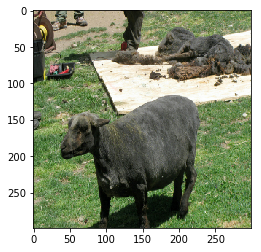

In [5]:
img = data_dump[0][0]["images"][0, :, :, :]
img = img - img.min()
img = img / 2.0
plt.imshow(img)

In [6]:
plt.imsave("buffer.jpg", img)
with tf.gfile.GFile("buffer.jpg", "rb") as f:
    enc_img = f.read()
print(type(enc_img))

<type 'str'>


In [7]:
print(im2txt.run_once(enc_img))

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
[('a <UNK> <UNK> sheep <UNK> away from it <UNK> <UNK>', 0.24515534291181026), ('a back sheep that is standing in the grass .', 0.1992867538110551), ('a <UNK> sheep is walking away from a <UNK> of its <UNK> .', 0.1940318817072944)]


In [8]:
VOCAB_FILE = "/home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt"

In [9]:
from im2txt.inference_utils import vocabulary
vocab = vocabulary.Vocabulary(VOCAB_FILE)

INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words


In [10]:
caption = data_dump[0][0]["target_seqs"][0, :]
print(caption)

[  0  43  48 362 362 362 106 362 362 149   3   2   0   0   0   0   0   0
   0]


In [11]:
caption = [vocab.id_to_word(w) for w in caption]
print(caption)

['a', 'black', 'sheep', '<UNK>', '<UNK>', '<UNK>', 'its', '<UNK>', '<UNK>', 'off', '.', '</S>', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


In [13]:
final_dump = []

for e in data_dump:
    e = e[0]
    for i in range(e["images"].shape[0]):
        
        img = e["images"][i, :, :, :]
        img = img - img.min()
        img = img / 2.0
        plt.imsave("buffer.jpg", img)
        with tf.gfile.GFile("buffer.jpg", "rb") as f:
            enc_img = f.read()
        beam_search_captions = im2txt.run_once(enc_img)
        seq_length = e["target_seqs"].shape[1]
        decoupled_softmax = e["softmax_outputs"][i*seq_length:(i+1)*seq_length, :]
        
        final_caption = ""
        for w in e["target_seqs"][i, :]:
            final_caption += str(vocab.id_to_word(w)) + " "
        
        final_element = {
            "image": img,
            "loss": e["losses"][i],
            "loss_weight": e["losses_weights"][i],
            "input_seq": e["input_seqs"][i, :],
            "target_seq": e["target_seqs"][i, :],
            "input_mask": e["input_mask"][i, :],
            "probabilities": decoupled_softmax,
            "beam_search_captions": beam_search_captions,
            "target_caption": final_caption
        }
        
        print(final_element["target_caption"])        
        print(final_element["beam_search_captions"][0][0])
        print
        
        final_dump.append(final_element)

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a black sheep <UNK> <UNK> <UNK> its <UNK> <UNK> off . </S> a a a a a a a 
a <UNK> <UNK> sheep <UNK> away from it <UNK> <UNK>

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im

INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a school bus parked with it 's stop sign closed . </S> a a a a a a a 
a school bus parked with it 's stop sign closed .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a small <UNK> table with all red <UNK> and a red table <UNK> . </S> a a a a 
a red table topped with four white pl

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
sheep grazing in the field on a sunny day </S> a a a a a a a a a 
sheep grazing in the field on a sunny day

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflo

INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
people are out walking in the street in the <UNK> . </S> a a a a a a a a a a 
a group of people on street with a traffic light in the background .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a large bottle of wine sitting on a kitchen counter . </S> a a a a a a a a a a 
a <UNK> kitchen full of <UNK> <UNK> and food

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializin

a stove that has several pots and pans on it . </S> a a a a a a a a a a 
a full view of a kitchen with pans and plates all over .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a restroom with a stainless steel toilet next to a <UNK> sink . </S> a a a a a a a a 
a bathroom with a stainless steel toilet and sink .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
two sheep with <UNK> <UNK> standing in a grass field . </S> a a a a a a 
two sheep with <UNK> <UNK> standing in a grass field .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-

INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a big cathedral with <UNK> stone work against a blue sky </S> a a a a a a 
a big cathedral with <UNK> stone work against a blue sky

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a person in a kitchen preparing food under a <UNK> </S> a a a a a a a 
a <UNK> is making food under a <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a group of people looking at an old motorcycle . </S> a a a a a a a 
an antique <UNK> motorcycle with a <UNK> <UNK> on display at an <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/trai

INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a street light with a <UNK> of snow on a <UNK> <UNK> next to a street . </S> 
a street light with a <UNK> of snow on a <UNK> <UNK> next to a street .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a little girl <UNK> with a giraffe with a <UNK> . </S> a a a a a a 
a giraffe is <UNK> <UNK> by a <UNK> <UNK> child

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing voca

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a kitchen that has a <UNK> and some cabinets in it </S> a a a a a a 
a kitchen that has a <UNK> and some cabinets in it

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
IN

INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
small dog in wire <UNK> <UNK> on motor <UNK> in city . </S> a a a 
a dog is inside of a covered cage on back of a motorcycle .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a <UNK> bathroom features a white toilet and sink and a beige bathtub . </S> a 
a bathroom scene <UNK> with a <UNK> , sink and toilet .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created 

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a dog is in a cage on the back of a motorcycle </S> a a a 
a dog is inside of a covered cage on back of a motorcycle .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
bathroom that has a toilet , shower , and sink . </S> a a a a 
ba

INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a <UNK> motorcycle parked in front of a <UNK> . </S> a a a a a a a a a 
a blue motor <UNK> parked in front of a <UNK> next to trash <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a small orange airplane with mountains in the <UNK> . </S> a a a a a a a a a 
an orange and white <UNK> parked with mountains in the <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:t

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a man in <UNK> <UNK> through an open door . </S> a a a a a a a a a 
a man in <UNK> <UNK> through an open door .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tenso

INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a <UNK> station toilet has not <UNK> <UNK> in <UNK> </S> a a a a a a a a a 
a white toilet with black water around it .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a piece of wood that is sitting in front of a toilet . </S> a a a a a a 
this bathroom <UNK> a lot of work <UNK> a <UNK> toilet seat and door

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabula

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a kitchen with chefs and <UNK> dishes of food . </S> a a a a a a 
a restaurant kitchen with <UNK> food on the counter .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
IN

INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
an <UNK> baby feeding <UNK> <UNK> from a bowl . </S> a a a a a a 
a <UNK> using a spoon eating from a plate

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a bath room with a toilet and a cat on the rug </S> a a a a 
a cat laying next to a white toilet in a bathroom .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:

INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a bicycle <UNK> on the stove and cabinets <UNK> inside the kitchen . </S> a a a a a 
a bicycle parked in a kitchen with a stove and cabinets .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.c

INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
two giraffes standing the open away <UNK> one giraffe <UNK> in the trees . </S> a a a a 
a couple of giraffes are standing in a field

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a group of <UNK> are running together as people <UNK> </S> a a a a a a a a 
a group of <UNK> are running together as people <UNK>

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabu

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a little girl standing next to a red bike near <UNK> . </S> a a a a a 
a little girl in a red <UNK> and <UNK> is near a red bike and red table .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/

INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a jet flying on its side in the bright blue sky . </S> a a a a a 
a jet flying through the air on a <UNK> day .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a truck driving down a <UNK> with a sign in the <UNK> . </S> a a a a 
a truck driving down a <UNK> with a sign in the <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btra

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a photograph of an outside with <UNK> <UNK> in the scene . </S> a a a a a 
an old <UNK> truck sitting by a yellow fire hydrant .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt

INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
little girl looking down at <UNK> with her bicycle with <UNK> wheels parked next to her . </S> 
a little girl in a red <UNK> and <UNK> is near a red bike and red table .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
two people in a kitchen area preparing food </S> a a a a a a a a a 
a restaurant kitchen with <UNK> food on the counter .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a bathroom that <UNK> a toilet and an open area shower . </S> a a a a a 
a <UNK> bathroom with toilet and <UNK> shower .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a giraffe <UNK> to <UNK> <UNK> grass . </S> a a a a a a a a a 


INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a kitchen <UNK> <UNK> <UNK> <UNK> in the corner </S> a a a a a a a 
a kitchen that has a <UNK> and some cabinets in it

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
people are walking down the sidewalk next to a building . </S> a a a a a 
a street corner with a large building on it .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 word

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a large clock on the wall above a <UNK> </S> a a a a a a a 
a table and chairs with a large clock on the wall .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
two sheep on top of a hill grazing . </S> a a a a a a a 
two sheep with 

a close up of a giraffe bending down <UNK> water </S> a a a a a a 
a giraffe <UNK> its <UNK> into a <UNK> of water .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a school bus is driving down a road . </S> a a a a a a a 
a school bus is moving down a <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/tra

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
two giraffes eating <UNK> off the trees in the woods </S> a a a a a a 
an <UNK> and a giraffe are walking through the woods .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a dirty looking bathroom with a sink and a toilet . </S> a

INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
the eating car of the train has empty <UNK> . </S> a a a a a a 
a <UNK> with <UNK> of <UNK> and large windows .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
view of a bathroom with white toilet and white sink </S> a a a a a a 
view of a bathroom with white toilet and white sink

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INF

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a couple of urinals mounted to a wall in a restroom . </S> a a a a a a a 
a couple of urinals mounted to a wall in a restroom .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a small brown dog sticking it 's head out of a car windo

INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a truck that is sitting behind a bus . </S> a a a a a a a a a a 
a bus and a few other <UNK> that <UNK> to <UNK> <UNK> down the road .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
the small bathroom has a <UNK> and white <UNK> . </S> a a a a a a a a a 
a bathroom has one black wall and a black floor

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary fro

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
the street light is covered in a <UNK> <UNK> of snow </S> a a a a a a 
a street light with a <UNK> of snow on a <UNK> <UNK> next to a street .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/tr

INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
many people sitting at a park bench near trees </S> a a a a a a a a 
many people sitting at a park bench near trees

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
several <UNK> on bicycles outside a white church . </S> a a a a a a a a 
a group of people riding bikes stopped in front of a building

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from fil

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a red table topped with four white place <UNK> . </S> a a a a a a a 
a red table topped with four white place <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO

INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
two giraffe 's <UNK> away from each other in a zoo <UNK> . </S> a a a 
<UNK> two giraffe are standing near a large <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a kitchen that has a stove and a <UNK> </S> a a a a a a a 
a <UNK> , <UNK> and sink in the kitchen

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow

INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a red double decker bus with an open air top . </S> a a a a a 
a red double decker bus with an open air top .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a bathroom with a yellow sink next to a white bath tub . </S> a a a 
double sink vanity next to a bathtub with a <UNK> in th

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a view of a bunch of <UNK> being <UNK> on a grill . </S> a a a a a 
a grill that has a bunch of <UNK> on it

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflo

INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
the city buses are parked together in the parking lot . </S> a a a a a a a 
a view of a parking lot with several buses .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a man with a <UNK> camera <UNK> a motorcycle <UNK> </S> a a a a a a a a 
a man is <UNK> some motor <UNK> coming down the road .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file:

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a toilet with a <UNK> on it inside a bathroom . </S> a a a a a a 
a bathroom scene with a white toilet covered with a red <UNK>

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-

INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
this is a <UNK> bench with a can sitting on it . </S> a a a a a 
a <UNK> bench with a can of <UNK> sitting on top .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a woman <UNK> a <UNK> <UNK> to a man . </S> a a a a a a a 
a woman <UNK> a <UNK> of her <UNK> to a man in front of <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 word

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
giraffes and ostriches are <UNK> a grassy area . </S> a a a a a a a a 
an <UNK> giraffe near a <UNK> and a bird in the grass .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
two bathroom sinks are shown in a <UNK> up bathroom . </S

INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
two sinks are shown that are blue and white <UNK> . </S> a a a a a a a a a a a 
two sinks are shown that are blue and white <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
some very <UNK> giraffes in a <UNK> area . </S> a a a a a a a a a a a a a 
a couple of giraffes are standing in a field

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary 

a small kitchen that <UNK> all of its space . </S> a a a a a a a a a a a a 
a small kitchen that <UNK> all of its space .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a stop light with a one way , <UNK> not <UNK> sign above it . </S> a a a a a a a 
a stop light is topped with a <UNK> not <UNK> <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoin

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a <UNK> <UNK> that is sitting on <UNK> . </S> a a a a a a a a 
a blue <UNK> airplane is parked at a <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
dirty bathroom floor with a toilet and a toilet <UNK> next to it . </S> a a 

INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a yellow and black fire hydrant next to dirt field . </S> a a a a a a 
a yellow water hydrant on the side of the road .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a <UNK> <UNK> is <UNK> on a wall in a <UNK> . </S> a a a a a 
view of a bathroom with white toilet and white sink

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INF

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a group of <UNK> <UNK> the <UNK> of some <UNK> truck . </S> a a a a a 
a group of birds on a truck with a person inside .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a toilet in a bathroom with its seat down . </S> a a a a a a 


a chef preparing food inside of a kitchen near a window . </S> a a a a 
a <UNK> is making food under a <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
the sheep are standing and grazing in a pasture . </S> a a a a a a 
a couple sheep eating grass in the green <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im

INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a man laying on his <UNK> with a towel on his head . </S> a a a 
this is a photo of <UNK> <UNK> back .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a small child eating <UNK> from a bowl in a kitchen </S> a a a a a 
a <UNK> using a spoon eating from a plate

INFO:tensorflow:Buil

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a view of a <UNK> bear in a glass <UNK> . </S> a a a a 
a <UNK> bear on display in a library .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfull

INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a passenger jet that is on a runway . </S> a a a a a a 
a <UNK> taking off from an airport runway .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a row of city buses parked in a lot </S> a a a a a a 
a view of a parking lot with several buses .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a <UNK> tiled counter in a small bathroom </S> a a a a a a a a a a 
this bathroom has a <UNK> hanging on the wall

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:ten

INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
some giraffes and ostriches in a grass field with trees . </S> a a a a a a a 
an <UNK> giraffe near a <UNK> and a bird in the grass .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a steel toilet and sink in a <UNK> bathroom . </S> a a a a a a a a 
a bathroom with a stainless steel toilet and sink .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from 

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a man <UNK> down between two bicycles </S> a a a a a a a a a a a 
a man <UNK> down between two bicycles

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Su

INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
little girl sitting on a bench next to a couple </S> a a a a a a 
a little girl is sitting on a bench <UNK> <UNK> while <UNK> her head .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a motorcycle on display at a <UNK> outdoor <UNK> . </S> a a a a a a 
an antique <UNK> motorcycle with a <UNK> <UNK> on display at an <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initi

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a small girl <UNK> on a wooden bench in front of a <UNK> . </S> a a 
a little girl is sitting on a bench <UNK> <UNK> while <UNK> her head .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a dark room with a long wooden table and a bike hanging on the wall . </S> a a a a a a a a a a a 
a room with a table and chairs and bikes hanging up .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a chef is cooking at the counter

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a <UNK> kitchen full of <UNK> <UNK> and food </S> a a a a a a a a a a a a a a a a a a 
a <UNK> kitchen full of <UNK> <UNK> and food

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
little <UNK> crying in the mirror while <UNK> hands 

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a <UNK> dark kitchen has an <UNK> <UNK> . </S> a a a a a a a 
a kitchen with a sink a <UNK> <UNK> on the wall and utensils hanging from a window .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
bike <UNK> in a city <UNK> with peopl

a plane flying with a <UNK> plane above it . </S> a a a a a a 
a pair of <UNK> flying in the air under a blue sky .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a <UNK> motorcycle parked <UNK> a car in the <UNK> </S> a a a a a a 
a <UNK> motorcycle parked <UNK> a car in the <UNK>

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/res

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a dirty large car on a city street . </S> a a a a a a a 
an old and large truck parked by a fire hydrant .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
there are four <UNK> <UNK> on the wall in a bathroom </S> a a a a a 
three ta

a <UNK> bath area with a <UNK> and blue and white bathtub . </S> a a a a 
double sink vanity next to a bathtub with a <UNK> in the <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a bunch of people cooking inside of a kitchen </S> a a a a a a a a 
a <UNK> of chefs working in a <UNK> kitchen .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /h

INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a <UNK> <UNK> sheep <UNK> away from it <UNK> <UNK> </S> a a a a a a a 
a <UNK> <UNK> sheep <UNK> away from it <UNK> <UNK>

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
two mirrors that are attached to a wall </S> a a a a a a a a a 
<UNK> <UNK> mirror attached to a bathroom wall



a motorcycle sitting under an <UNK> next to a bunch of <UNK> </S> a a a a a 
a motorcycle sitting under an <UNK> next to a bunch of <UNK>

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a man cutting up vegetables on top of a food <UNK> . </S> a a a a a 
a man cutting up vegetables on top of a food <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpo

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
three urinals line a tiled wall in a restroom . </S> a a a a a a a 
three <UNK> urinals are <UNK> <UNK> <UNK> one .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
<UNK> motorcycle parked in <UNK> parking lot on bright sunny day . <

INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a couple sheep eating grass in the green <UNK> . </S> a a a a a a a 
a couple sheep eating grass in the green <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
an old style airplane is parked while people <UNK> in the background . </S> a a a a 
a blue <UNK> airplane is parked at a <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
two bathroom sinks in front of a large mirror , with two <UNK> </S> a a a a 
lights <UNK> on two <UNK> , white , <UNK> sinks .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a black and white <UNK> of <UNK> grazing and a large moun

INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a bowl sitting in a bathroom across from a toilet . </S> a a a a a a 
a white toilet in a bathroom under a window .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
there is a <UNK> <UNK> in a bowl of food . </S> a a a a a a 
a white bowl filled with <UNK> vegetables and a spoon .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a giraffe is <UNK> <UNK> by a <UNK> <UNK> child </S> a a a a a a a a 
a giraffe is <UNK> <UNK> by a <UNK> <UNK> child

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO

INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a bathroom toilet sitting next to a few <UNK> of toilet paper . </S> a a a a a 
a bathroom with a toilet and white walls .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a stuffed bear is in a display <UNK> in a library . </S> a a a a a a 
a <UNK> bear on display in a library .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:

INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
the <UNK> is <UNK> ready for his <UNK> to <UNK> ready . </S> a a 
a man with a <UNK> <UNK> and an <UNK> using a brick oven .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a man standing in a parked train doorway . </S> a a a a a 


(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a blue and white bus some cars a yellow bus and trees </S> a a 
one bus stopped at an intersection , while another <UNK> past it .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ck

a bench and ground sit covered in snow </S> a a a a a a 
snow <UNK> <UNK> in a park during <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a toilet and a speaker sitting on the floor . </S> a a a a 
a white toilet sitting in the corner of a room next to a black <UNK> .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
the <UNK> of the bathroom sink in a mirror </S> a a a a a a a a a a a 
the <UNK> of the bathroom sink in a mirror

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:ten

INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a toilet with a trash can and a <UNK> of toilet paper on top </S> a a a a a a 
a toilet that is next to a <UNK> and some toilet paper .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a bathroom that has a toilet and some <UNK> <UNK> all over </S> a a a a a a a a 
a white toilet in

INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a man standing at the <UNK> of a passenger train car </S> a a a a a a a a a a 
a man standing at the <UNK> of a passenger train car

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a blue vintage car is driving down the street . </S> a a a a a a a a a a a 
a blue vintage car is driving down the street .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabul

(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-82314
a large black <UNK> <UNK> on the back of a park bench . </S> a a a a a a a a 
a large black <UNK> <UNK> on the back of a park bench .

INFO:tensorflow:Building model.
(?, 12000)
INFO:tensorflow:Initializing vocabulary from file: /home/btrabucco/research/im2txt/im2txt/data/coco/word_counts.txt
INFO:tensorflow:Created vocabulary with 363 words
INFO:tensorflow:Loading model from checkpoint: /home/btrabucco/research/im2txt/im2txt/train/model.ckpt-82314
INFO:tensorflow:Restoring parameters from /home/btrabucco/research/im2txt/im2txt/train/model

In [14]:
with open(
        "/home/btrabucco/research/im2txt/im2txt/data/final_dump.pkl",
        "wb") as f:
    for e in final_dump:
        pkl.dump(e, f)